In [1]:
import pandas, seaborn, os, numpy

import sklearn, sklearn.cluster
import scipy, scipy.stats

In [2]:
%matplotlib inline
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(9, 6), 'axes.labelsize':20})

# 0. user-defined variables

In [3]:
home_dir = '/Users/adrian/'

In [4]:
full_wound_metabolic_file = '/Users/adrian/gd15/hi/research/kerecis_metabolomics_new/data/clusters/df_logFC_comb_FULL.csv'

annotation_file = '/home/adrian/gd15/hi/research/kerecis/data/clusters/Table 1- Adrian.xlsx'
annotation_file = '/home/adrian/gd15/hi/research/kerecis/data/clusters/Table 1 Updated.xlsx'
annotation_partial_file = '/Users/adrian/gd15/hi/research/kerecis_metabolomics_new/data/clusters/new_annotation/Table 1.xlsx'
annotation_full_file = '/Users/adrian/gd15/hi/research/kerecis_metabolomics_new/data/clusters/new_annotation/Table 2.xlsx'

In [5]:
days = [7, 14, 21, 28, 60]

# 1. read data

## 1.1. metabolite quantification

In [6]:
profiles = pandas.read_csv(full_wound_metabolic_file, index_col=0)

print(profiles.shape)
profiles.head()

(244, 5)


,logFC07,logFC14,logFC21,logFC28,logFC60
mz,,,,,
60.0452_pos,-0.083854,0.191472,0.982798,0.988894,0.743300
60.05658_pos,-0.038624,0.089157,0.781340,0.774211,0.811386
62.02452_pos,1.505635,1.319179,1.076527,1.081010,0.233993
71.02976_pos,1.279493,0.952287,0.857605,0.819389,0.030744
73.53242_pos,1.519172,1.332466,1.114554,1.120287,0.153851


In [7]:
a = profiles.max(axis=1).to_list()
b = profiles.min(axis=1).to_list()
for i in range(len(a)):
    diff = abs(a[i] - b[i])
    if diff < numpy.log2(1.75):
        print(a[i], b[i], diff)

0.6927274680700108 -0.0955987649792193 0.7883262330492301
0.9077684039123232 0.1552095236758309 0.7525588802364922
1.0617807185565136 0.2626839108393354 0.7990968077171782
0.7695048146110032 0.0361291555596226 0.7333756590513806
1.0684430155173696 0.2717063065333767 0.796736708983993
0.9794713586934152 0.2161151326975322 0.763356225995883
0.995913418258253 0.1890155595051411 0.8068978587531119
0.9941189557786302 0.1941583278954602 0.79996062788317
0.8977662505136887 0.1095673256993303 0.7881989248143585


In [8]:
zscore_profiles = pandas.DataFrame(scipy.stats.zscore(profiles, axis=1), index=profiles.index)

print(zscore_profiles.shape)
zscore_profiles.head()

(244, 5)


,logFC07,logFC14,logFC21,logFC28,logFC60
mz,,,,,
60.0452_pos,-1.490173,-0.857387,0.961330,0.975340,0.410889
60.05658_pos,-1.386680,-1.047310,0.791042,0.772108,0.870840
62.02452_pos,1.062214,0.633861,0.076405,0.086705,-1.859184
71.02976_pos,1.193809,0.399200,0.169268,0.076462,-1.838739
73.53242_pos,0.998931,0.603039,0.140981,0.153138,-1.896089


In [9]:
print(zscore_profiles.iloc[2, :])
print(numpy.mean(zscore_profiles.iloc[2, :]))
print(numpy.std(zscore_profiles.iloc[2, :]))

logFC07    1.062214
logFC14    0.633861
logFC21    0.076405
logFC28    0.086705
logFC60   -1.859184
Name: 62.02452_pos, dtype: float64
-2.6645352591003756e-16
1.0


## 1.2. read annotation

In [10]:
#
# first version, working with input file Table 1- Adrian.xlsx
#
#shared_annotation = pandas.read_excel(annotation_file, sheet_name='Sheet3')

#
# second version, working with the input file, Table 1 Updated.xlsx
#
# annotation_partial = pandas.read_excel(annotation_file, sheet_name='DPT wounds')
# annotation_full = pandas.read_excel(annotation_file, sheet_name='FT wounds')
# annotation_partial.drop(columns=['Identification Method', 'Common Fragments '], inplace=True)
# annotation_full.drop(columns=['Identification Method', 'Common Fragments ', 'Unnamed: 6', 'Unnamed: 7'], inplace=True)
# print(annotation_partial.shape)
# print(annotation_full.shape)
# annotation_partial.head()

#
# third version, working with the input file Table 1.xlsx
#

In [11]:
annotation_partial = pandas.read_excel(annotation_partial_file, sheet_name='DPT wounds', skiprows=1, usecols=['mode', 'm/z', 'Retention time', 'Metabolite'])
print(annotation_partial.shape)
annotation_partial.head()

(25, 4)


,Metabolite,mode,m/z,Retention time
0,Hypotaurine,pos/neg,92.01728,4.400000
1,Allantoin,neg,157.03668,3.373333
2,Arginine,pos,175.11927,5.001667
3,Histamine,pos,95.06104,4.743333
4,"3,4-Dihydroxymandelic acid",pos,84.96055,5.806667


In [12]:
annotation_full = pandas.read_excel(annotation_full_file, sheet_name='FT wounds', skiprows=1, usecols=['Ion mode', 'm/z', 'Retention time', 'Metabolite'])
annotation_full.rename(columns={'Ion mode':'mode'}, inplace=True)
print(annotation_full.shape)
annotation_full.head()

(27, 4)


,Metabolite,mode,m/z,Retention time
0,Histamine,pos,95.06082,5.056667
1,Serine,neg,104.03505,4.593333
2,Hypotaurine,pos /neg,110.02764 / 108.01206,4.441667
3,Histidine,pos /neg,156.07728 / 154.06188,5.045000
4,Allantoin,neg,157.03668,3.373333


In [13]:
# join the two annotations
shared_annotation = pandas.concat([annotation_full, annotation_partial])
print(shared_annotation.shape)
shared_annotation.head()

(52, 4)


,Metabolite,mode,m/z,Retention time
0,Histamine,pos,95.06082,5.056667
1,Serine,neg,104.03505,4.593333
2,Hypotaurine,pos /neg,110.02764 / 108.01206,4.441667
3,Histidine,pos /neg,156.07728 / 154.06188,5.045000
4,Allantoin,neg,157.03668,3.373333


In [14]:
# drop duplicates and replace typos
shared_annotation.drop_duplicates(inplace=True)
shared_annotation.shape

shared_annotation.replace({'pos /neg':'pos/neg'}, inplace=True)

shared_annotation

,Metabolite,mode,m/z,Retention time
0,Histamine,pos,95.06082,5.056667
1,Serine,neg,104.03505,4.593333
2,Hypotaurine,pos/neg,110.02764 / 108.01206,4.441667
3,Histidine,pos/neg,156.07728 / 154.06188,5.045000
4,Allantoin,neg,157.03668,3.373333
5,Citrulline,neg,174.08813,4.621667
6,Arginine,pos,175.11927,5.001667
7,Cystathionine,neg,221.06041,5.383333
8,Cytidine,neg,240.92911,4.035000
9,Hydroxyproline,neg,130.05016,4.378333


In [15]:
matching_threshold = 1e-2
modes = ['pos', 'neg', 'pos/neg']
formatted_annotation = {}

for mode in modes:
    
    print('working with {} mode'.format(mode))
    
    # build variables that can be compared to annotation
    print('adapting observed features')
    observed_features = [element for element in zscore_profiles.index.to_list() if mode in element]
    observed_features_float = [float(element.split('_')[0]) for element in zscore_profiles.index.to_list() if mode in element]
    
    print(len(observed_features), observed_features[:4])
    print(len(observed_features_float), observed_features_float[:4])
    print()
    
    # iterate annotation to find matches in measured features. should have a match to every single annotation
    annotated = shared_annotation[shared_annotation['mode'] == mode]
    print('annotation shape found:', annotated.shape)
    for element in annotated['m/z']:
        name = annotated[annotated['m/z'] == element]['Metabolite'].values[0]
        
        print('\t working with {} {} {}'.format(mode, element, name))
        for i in range(len(observed_features_float)):
            diff = numpy.abs(element - observed_features_float[i])
            if diff < matching_threshold:
                print('\t\t MATCH:', diff, element, observed_features[i])
                formatted_annotation[observed_features[i]] = name
    
    # pos-neg boundary
    print()
    
for key in formatted_annotation:
    print(key, formatted_annotation[key])
print(len(formatted_annotation))

working with pos mode
adapting observed features
174 ['60.0452_pos', '60.05658_pos', '62.02452_pos', '71.02976_pos']
174 [60.0452, 60.05658, 62.02452, 71.02976]

annotation shape found: (30, 4)
	 working with pos 95.06082 Histamine
		 MATCH: 0.0 95.06082 95.06082_pos
		 MATCH: 0.00021999999999877673 95.06082 95.06104_pos
	 working with pos 175.11927 Arginine
		 MATCH: 0.0 175.11927 175.11927_pos
	 working with pos 708.63496 S-adenosyl methionine
		 MATCH: 0.0 708.63496 708.63496_pos
	 working with pos 148.0799 Glutamine
		 MATCH: 0.0 148.0799 148.0799_pos
	 working with pos 220.11887 Pantothenic acid
		 MATCH: 0.0 220.11887 220.11887_pos
	 working with pos 298.10262 5'-Deoxy-5'-methylthioadenosine  
		 MATCH: 0.0 298.10262 298.10262_pos
	 working with pos 777.8926 Oxidized glutathione
		 MATCH: 0.0 777.8926 777.8926_pos
	 working with pos 828.9304 Leukotriene C4
		 MATCH: 0.0 828.9304 828.9304_pos
	 working with pos 118.08662 Valine/Betaine
		 MATCH: 0.0 118.08662 118.08662_pos
	 worki

# 2. visualization and formatting

In [16]:
print(zscore_profiles.max())
print(zscore_profiles.min())

logFC07    1.959745
logFC14    1.435840
logFC21    1.811548
logFC28    1.657814
logFC60    1.259948
dtype: float64
logFC07   -1.963852
logFC14   -1.393099
logFC21   -0.573176
logFC28   -1.074903
logFC60   -1.997137
dtype: float64


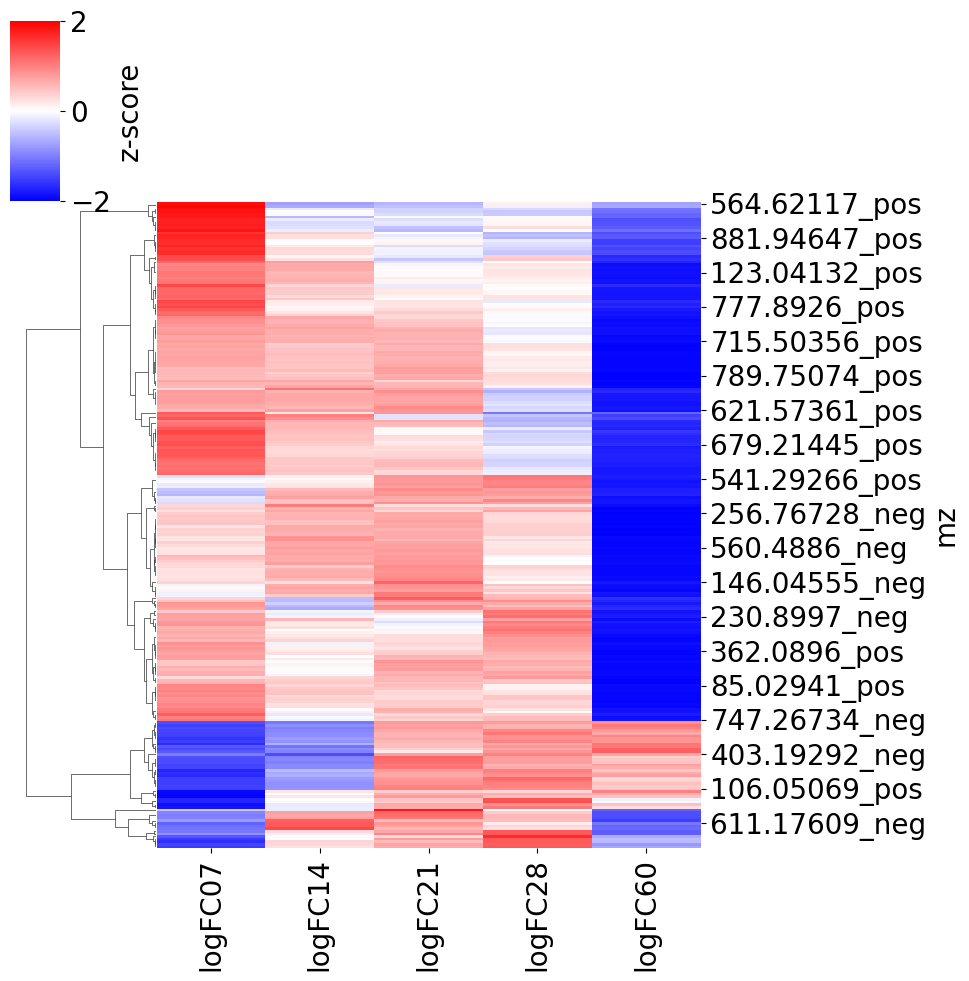

In [17]:
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.clustermap(zscore_profiles, cmap='bwr', vmin=-2, vmax=2, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})

In [18]:
x = zscore_profiles.to_numpy()
x

array([[-1.49017261, -0.85738675,  0.96132976,  0.97534024,  0.41088936],
       [-1.38668006, -1.04730988,  0.79104184,  0.77210809,  0.87084001],
       [ 1.06221391,  0.63386085,  0.07640512,  0.08670453, -1.8591844 ],
       ...,
       [ 0.64885422, -0.08319587,  0.66505973,  0.68318412, -1.91390221],
       [ 0.24492994,  0.62758681,  0.8596667 ,  0.20789327, -1.94007672],
       [ 0.52089942,  0.49519326,  0.68939048,  0.27726987, -1.98275304]])

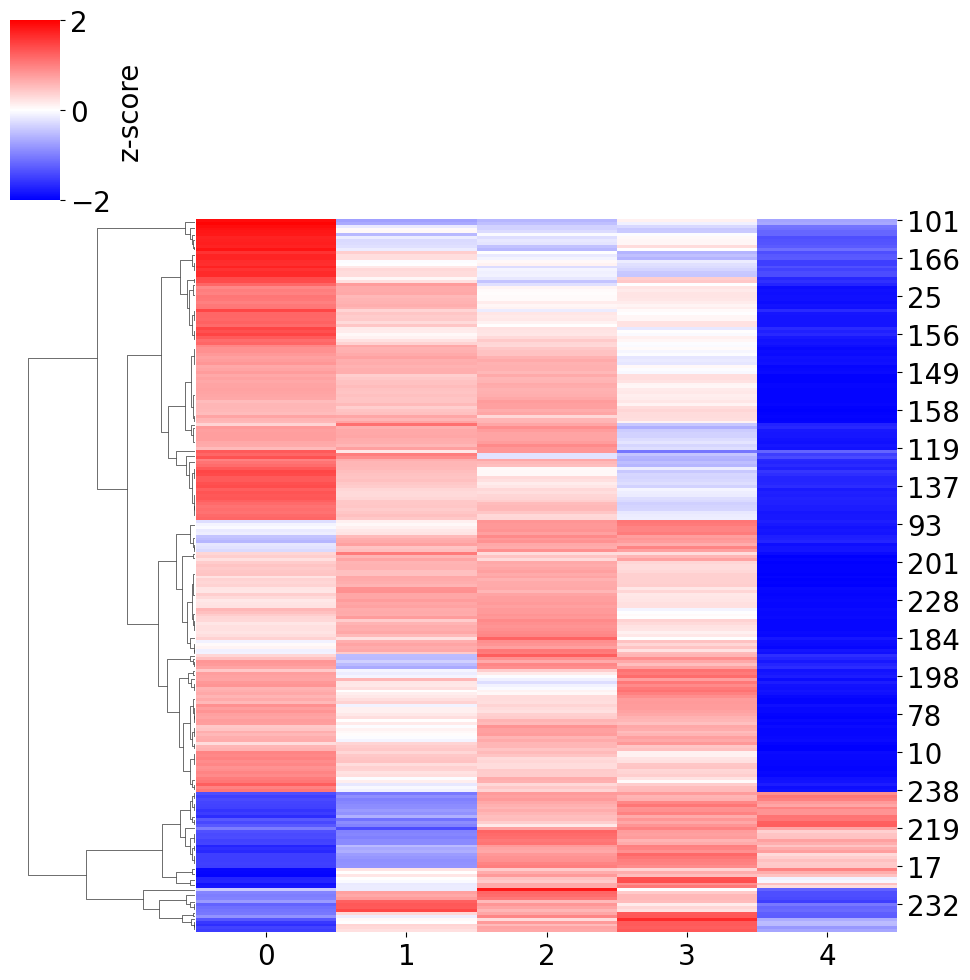

In [19]:
seaborn.clustermap(x, cmap='bwr', vmin=-2, vmax=2, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})

# 3. analysis

In [20]:
number_elements = zscore_profiles.shape[0]
print('number of elements {}'.format(number_elements))
fine = int(number_elements/5)
coarse = int(number_elements/20)
print(coarse, fine)
k_range = range(coarse, fine+1)

k_range = range(2, 12)

number of elements 244
12 48


2 0.8180859198848908 397.81037711640175 0.6263855489775243
3 0.7261404701804898 286.4079560992014 0.7375105800636418
4 0.5559394109403958 244.5850814591597 0.7180081930380159
5 0.4300963279272226 273.95263994615533 0.9587405907728886
6 0.42083067823562736 225.44294944724183 0.8672141552289602
7 0.4469677012306525 234.14922816328615 0.8657133084035292
8 0.44909429725410305 221.79726253673002 0.7827028431552816

Cluster c0 skyblue with 92 gene indices: [  2   3   4   5   6   7   8  16  18  25  27  30  32  33  40  47  48  50
  52  58  59  63  64  68  76  77  80  82  83  88  90 102 103 104 105 106
 107 108 110 111 112 113 114 117 118 119 120 122 123 124 125 126 127 128
 132 133 134 135 136 137 138 139 142 145 146 147 148 149 150 151 153 154
 155 156 158 159 160 161 162 163 164 165 166 181 195 197 203 204 215 226
 235 243]

148.0799_pos Glutamine
151.98453_pos Cystine
220.11887_pos Pantothenic acid
298.10262_pos 5'-Deoxy-5'-methylthioadenosine  
588.63445_pos LPC(20:4)
777.8926_pos Oxidized

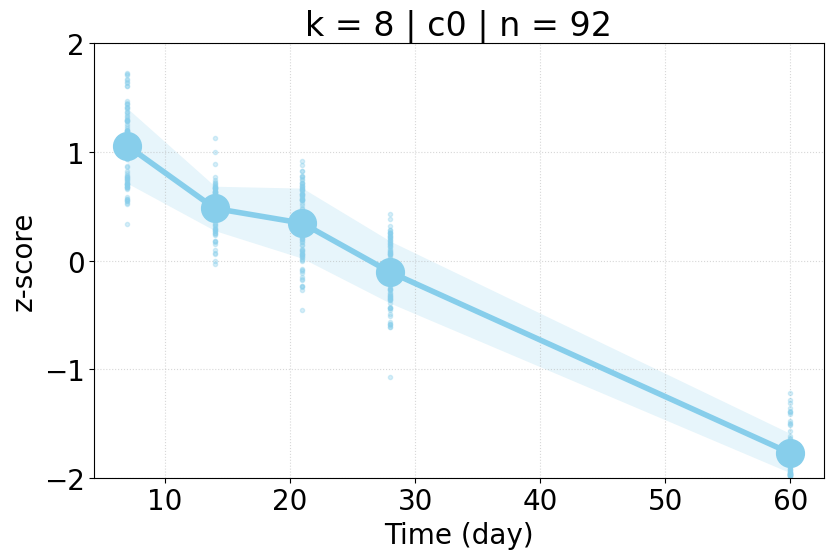


Cluster c1 or 6 tab:green with 93 gene indices: [  9  10  23  24  26  29  31  34  36  38  41  44  45  46  53  54  60  61
  62  65  66  67  69  70  71  74  75  78  79  81  84  89  91  93  94  95
  96 109 115 121 131 144 152 157 170 171 172 173 174 176 178 179 182 183
 184 185 189 190 193 196 198 199 201 202 205 206 209 211 212 213 214 216
 217 218 220 221 222 223 224 227 228 229 230 231 233 234 236 237 238 239
 240 241 242]

84.96055_pos 3,4-Dihydroxymandelic acid
118.08662_pos Valine/Betaine
125.98727_pos 3,4-Dihydroxymandelic acid
152.05761_pos Guanine
238.04632_pos S-Adenosylhomocysteine
362.0896_pos NADH
364.06663_pos GMP
240.92911_neg Cytidine
359.99008_neg N-acetyl aspartate
385.93804_neg Proline 


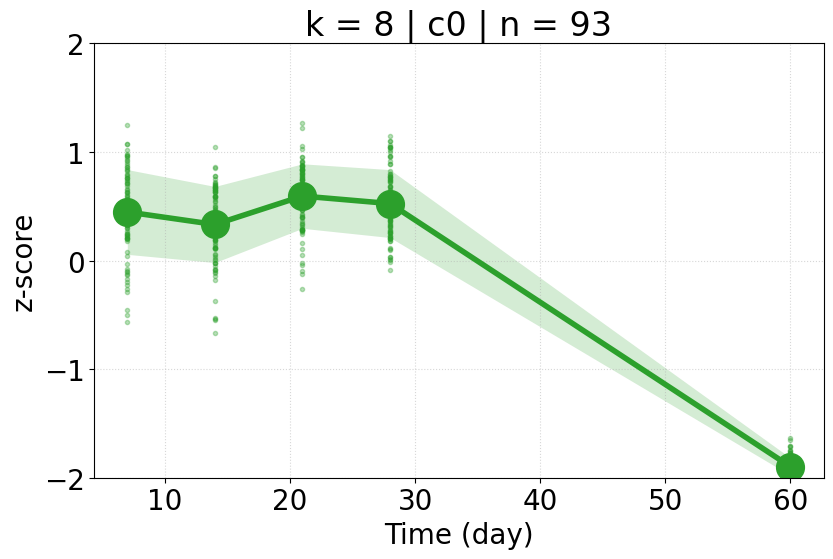


Cluster c2 tab:orange with 33 gene indices: [  0   1  11  12  13  14  15  17  19  20  21  22  35  37  39  42  43  57
  72  73  85  86  87  92 175 186 187 188 191 192 210 219 225]

95.06082_pos Histamine
95.06104_pos Histamine
175.11927_pos Arginine
104.03505_neg Serine
157.03668_neg Allantoin
174.08813_neg Citrulline


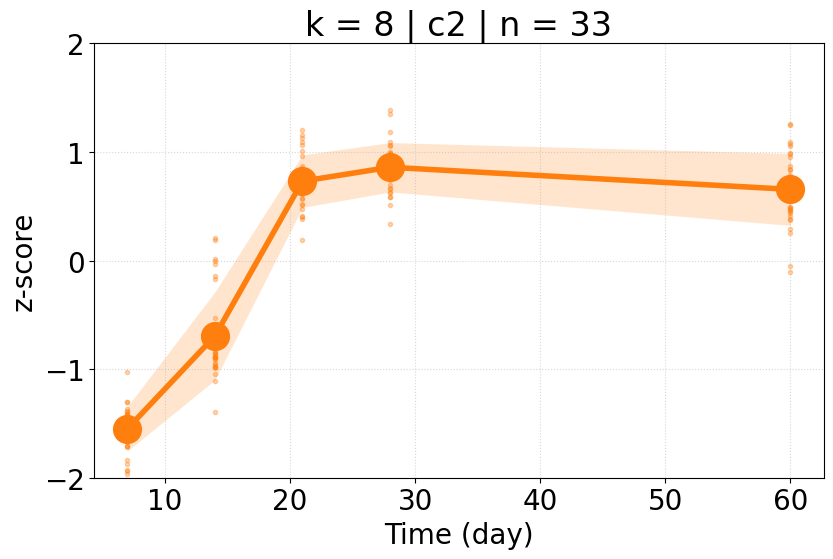


Cluster c3 cyan with 11 gene indices: [ 49  97  98  99 100 101 129 130 140 141 143]

564.28772_pos LPC(18:2)
708.63496_pos S-adenosyl methionine


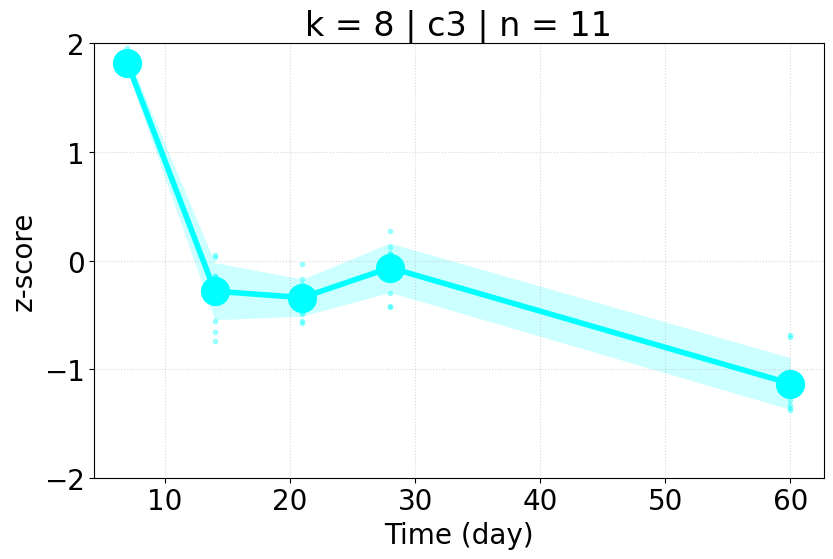


Cluster c4 tab:purple with 7 gene indices: [116 167 168 169 177 180 208]

108.01206_neg Hypotaurine
130.05016_neg Hydroxyproline


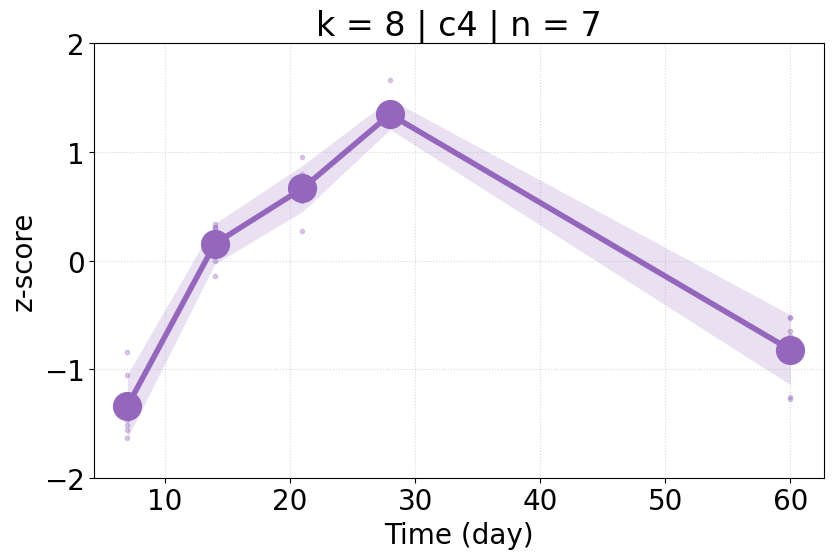


Cluster c5 tab:pink with 1 gene indices: [56]



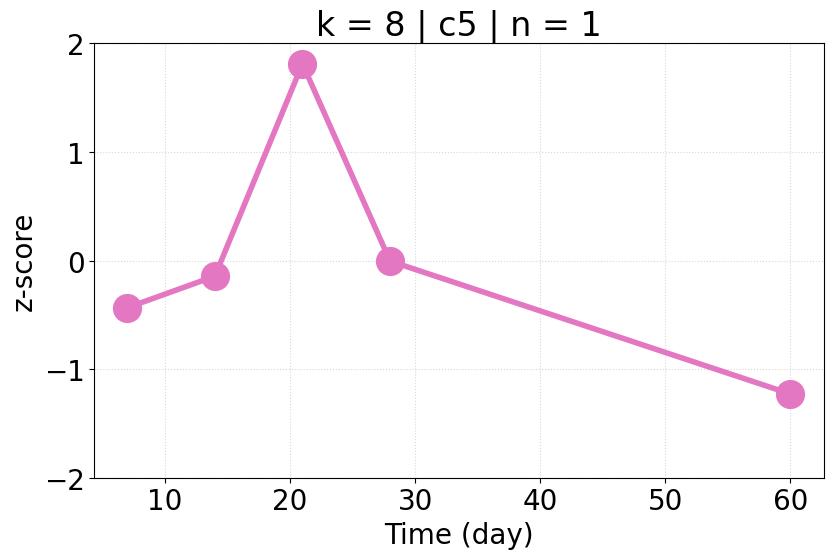


Cluster c7 magenta with 7 gene indices: [ 28  51  55 194 200 207 232]

223.07586_pos Cystathionine
221.06041_neg Cystathionine
242.07918_neg Cytidine


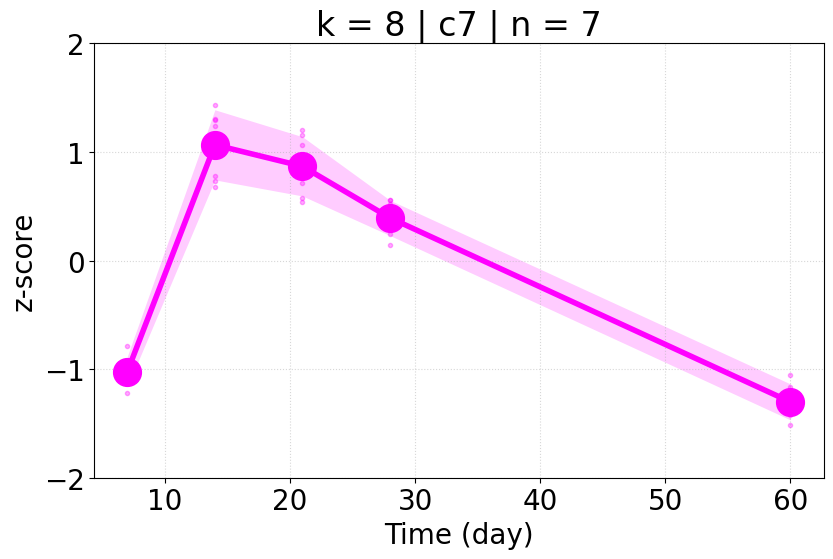

9 0.40995655051857915 224.78878118041385 0.8848452321007783
10 0.400285319120178 220.70359566431603 0.9241553672635099
11 0.39988658181551584 212.07275448695302 0.9050944607598442


In [21]:
p_ss = []; p_khi = []; p_dbi = []; all_labels = []

for k in k_range:

    partition = sklearn.cluster.AgglomerativeClustering(n_clusters=k, metric='cosine', linkage='complete').fit(x)
    labels = partition.labels_

    ss = sklearn.metrics.silhouette_score(x, labels, metric='cosine')
    khi = sklearn.metrics.calinski_harabasz_score(x, labels)
    dbi = sklearn.metrics.davies_bouldin_score(x, labels)

    print(k, ss, khi, dbi)
    
    p_ss.append(ss)
    p_khi.append(khi)
    p_dbi.append(dbi)
    all_labels.append(labels)
    
    if k == 8:
        
        # plotting first descending
        clusterID = 0
        indices = numpy.where(labels == clusterID)[0]
        the_color = 'skyblue'
        print('\nCluster c{} {} with {} gene indices: {}\n'.format(clusterID, the_color, len(indices), indices))
        cluster = zscore_profiles.iloc[indices, :]
        means = cluster.mean()
        stds = cluster.std()
        top = means + stds
        bottom = means - stds
        for element in cluster.index:
            if element in formatted_annotation:
                print(element, formatted_annotation[element])
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '.', alpha=1/3, lw=3, color=the_color)
        
        matplotlib.pyplot.plot(days, means, 'o-', color=the_color, lw=4, ms=20)
        
        matplotlib.pyplot.fill_between(days, top, bottom, color=the_color, alpha=0.2, lw=0)
            
        
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('z-score')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        matplotlib.pyplot.ylim([-2, 2])
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        
        matplotlib.pyplot.show()
        #matplotlib.pyplot.savefig('{}.svg'.format(the_color))
        #matplotlib.pyplot.clf()
        
        # plotting second down
        the_color = 'tab:green'
        indices = numpy.where((labels == 1) | (labels == 6))[0]
        print('\nCluster c{} {} with {} gene indices: {}\n'.format('1 or 6', the_color, len(indices), indices))
        cluster = zscore_profiles.iloc[indices, :]
        means = cluster.mean()
        stds = cluster.std()
        top = means + stds
        bottom = means - stds
        for element in cluster.index:
            if element in formatted_annotation:
                print(element, formatted_annotation[element])
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '.', alpha=1/3, lw=3, color=the_color)
        
        matplotlib.pyplot.plot(days, means, 'o-', color=the_color, lw=4, ms=20)
        
        matplotlib.pyplot.fill_between(days, top, bottom, color=the_color, alpha=0.2, lw=0)
            
        
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('z-score')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        matplotlib.pyplot.ylim([-2, 2])
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        matplotlib.pyplot.show()
        #matplotlib.pyplot.savefig('{}.svg'.format(the_color))
        #matplotlib.pyplot.clf()
        
        # plotting another cluster
        clusterID = 2
        the_color = 'tab:orange'
        indices = numpy.where(labels == clusterID)[0]
        print('\nCluster c{} {} with {} gene indices: {}\n'.format(clusterID, the_color, len(indices), indices))
        cluster = zscore_profiles.iloc[indices, :]
        means = cluster.mean()
        stds = cluster.std()
        top = means + stds
        bottom = means - stds
        for element in cluster.index:
            if element in formatted_annotation:
                print(element, formatted_annotation[element])
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '.', alpha=1/3, lw=3, color=the_color)
        
        matplotlib.pyplot.plot(days, means, 'o-', color=the_color, lw=4, ms=20)
        
        matplotlib.pyplot.fill_between(days, top, bottom, color=the_color, alpha=0.2, lw=0)
            
        
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('z-score')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        matplotlib.pyplot.ylim([-2, 2])
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        matplotlib.pyplot.show()
        #matplotlib.pyplot.savefig('{}.svg'.format(the_color))
        #matplotlib.pyplot.clf()
        
        # plotting another cluster
        clusterID = 3
        the_color = 'cyan'
        indices = numpy.where(labels == clusterID)[0]
        print('\nCluster c{} {} with {} gene indices: {}\n'.format(clusterID, the_color, len(indices), indices))
        cluster = zscore_profiles.iloc[indices, :]
        means = cluster.mean()
        stds = cluster.std()
        top = means + stds
        bottom = means - stds
        for element in cluster.index:
            if element in formatted_annotation:
                print(element, formatted_annotation[element])
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '.', alpha=1/3, lw=3, color=the_color)
        
        matplotlib.pyplot.plot(days, means, 'o-', color=the_color, lw=4, ms=20)
        
        matplotlib.pyplot.fill_between(days, top, bottom, color=the_color, alpha=0.2, lw=0)
            
        
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('z-score')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        matplotlib.pyplot.ylim([-2, 2])
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        matplotlib.pyplot.show()
        #matplotlib.pyplot.savefig('{}.svg'.format(the_color))
        #matplotlib.pyplot.clf()
        
        # plotting another cluster
        clusterID = 4
        the_color = 'tab:purple'
        indices = numpy.where(labels == clusterID)[0]
        print('\nCluster c{} {} with {} gene indices: {}\n'.format(clusterID, the_color, len(indices), indices))
        cluster = zscore_profiles.iloc[indices, :]
        means = cluster.mean()
        stds = cluster.std()
        top = means + stds
        bottom = means - stds
        for element in cluster.index:
            if element in formatted_annotation:
                print(element, formatted_annotation[element])
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '.', alpha=1/3, lw=3, color=the_color)
        
        matplotlib.pyplot.plot(days, means, 'o-', color=the_color, lw=4, ms=20)
        
        matplotlib.pyplot.fill_between(days, top, bottom, color=the_color, alpha=0.2, lw=0)
            
        
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('z-score')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        matplotlib.pyplot.ylim([-2, 2])
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        matplotlib.pyplot.show()
        #matplotlib.pyplot.savefig('{}.svg'.format(the_color))
        #matplotlib.pyplot.clf()
        
        # plotting another cluster
        clusterID = 5
        the_color = 'tab:pink'
        indices = numpy.where(labels == clusterID)[0]
        print('\nCluster c{} {} with {} gene indices: {}\n'.format(clusterID, the_color, len(indices), indices))
        cluster = zscore_profiles.iloc[indices, :]
        means = cluster.mean()
        stds = cluster.std()
        top = means + stds
        bottom = means - stds
        for element in cluster.index:
            if element in formatted_annotation:
                print(element, formatted_annotation[element])
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '.', alpha=1/3, lw=3, color=the_color)
        
        matplotlib.pyplot.plot(days, means, 'o-', color=the_color, lw=4, ms=20)
        
        matplotlib.pyplot.fill_between(days, top, bottom, color=the_color, alpha=0.2, lw=0)
            
        
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('z-score')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        matplotlib.pyplot.ylim([-2, 2])
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        matplotlib.pyplot.show()
        #matplotlib.pyplot.savefig('{}.svg'.format(the_color))
        #matplotlib.pyplot.clf()
        
        # plotting another cluster
        clusterID = 7
        the_color = 'magenta'
        indices = numpy.where(labels == clusterID)[0]
        print('\nCluster c{} {} with {} gene indices: {}\n'.format(clusterID, the_color, len(indices), indices))
        cluster = zscore_profiles.iloc[indices, :]
        means = cluster.mean()
        stds = cluster.std()
        top = means + stds
        bottom = means - stds
        for element in cluster.index:
            if element in formatted_annotation:
                print(element, formatted_annotation[element])
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '.', alpha=1/3, lw=3, color=the_color)
        
        matplotlib.pyplot.plot(days, means, 'o-', color=the_color, lw=4, ms=20)
        
        matplotlib.pyplot.fill_between(days, top, bottom, color=the_color, alpha=0.2, lw=0)
            
        
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('z-score')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        matplotlib.pyplot.ylim([-2, 2])
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        matplotlib.pyplot.show()
        #matplotlib.pyplot.savefig('{}.svg'.format(the_color))
        #matplotlib.pyplot.clf()

# 4. plotting

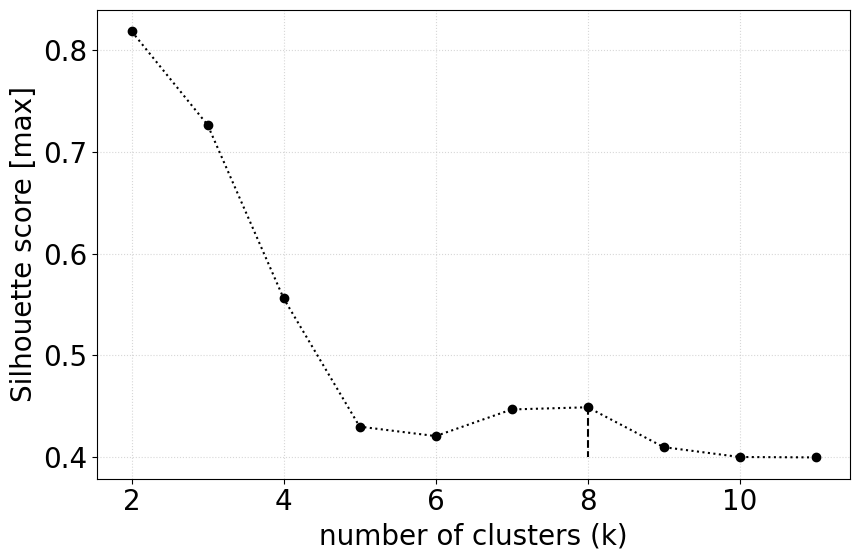

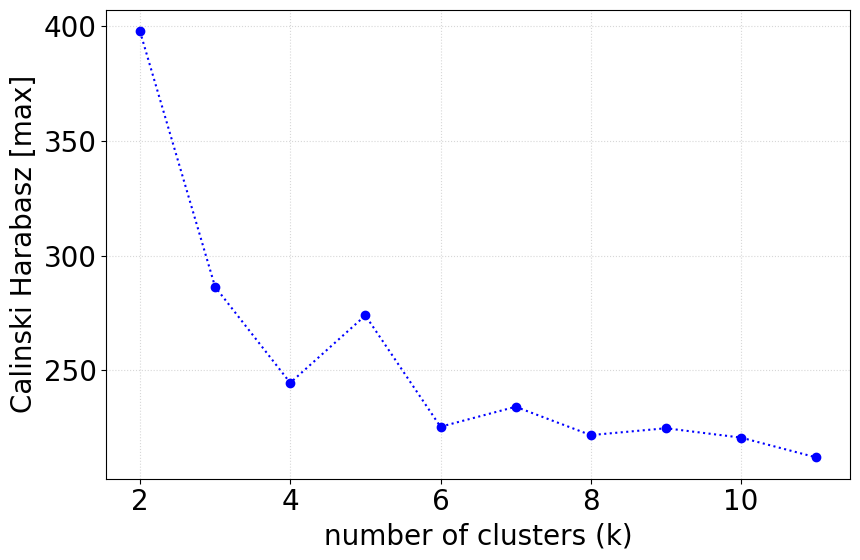

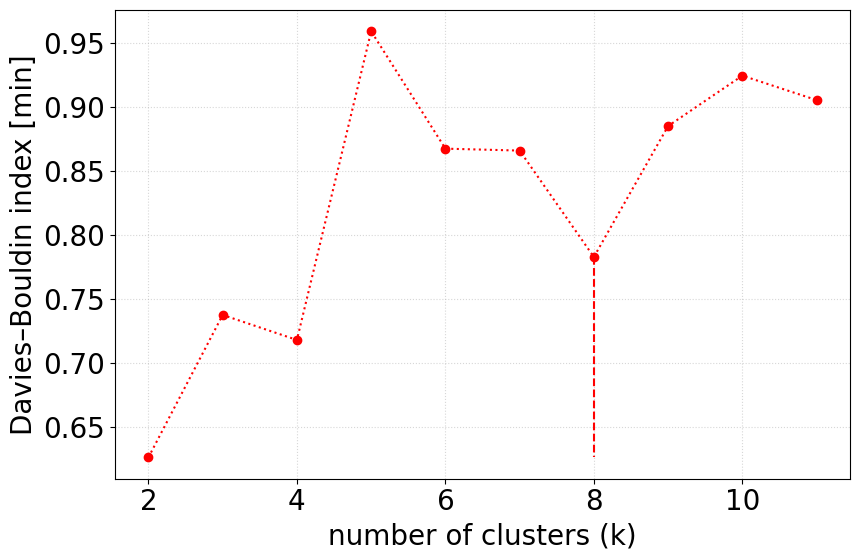

In [22]:
best_partition_index = 6

matplotlib.pyplot.plot(k_range, p_ss, 'ok')
matplotlib.pyplot.plot(k_range, p_ss, ':', color='black')
a = k_range[best_partition_index]
b = p_ss[best_partition_index]
c= numpy.min(p_ss)
matplotlib.pyplot.plot([a, a], [b, c], '--', color='black')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Silhouette score [max]')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

matplotlib.pyplot.plot(k_range, p_khi, 'ob')
matplotlib.pyplot.plot(k_range, p_khi, ':', color='blue')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Calinski Harabasz [max]')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

matplotlib.pyplot.plot(k_range, p_dbi, 'or')
matplotlib.pyplot.plot(k_range, p_dbi, ':', color='red')

a = k_range[best_partition_index]
b = p_dbi[best_partition_index]
c= numpy.min(p_dbi)
matplotlib.pyplot.plot([a, a], [b, c], '--', color='red')

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Davies–Bouldin index [min]')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## 4.1. heatmap

In [23]:
groupings = all_labels[best_partition_index]
groupings

array([2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2,
       2, 6, 6, 0, 1, 0, 7, 1, 0, 1, 0, 0, 1, 2, 6, 2, 6, 2, 0, 6, 2, 2,
       6, 1, 1, 0, 0, 3, 0, 7, 0, 6, 6, 7, 5, 2, 0, 0, 6, 6, 6, 0, 0, 1,
       6, 6, 0, 1, 6, 1, 2, 2, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 2, 2, 2,
       0, 6, 0, 6, 2, 6, 6, 6, 6, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 6,
       0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 3, 3, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 6, 0,
       0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 6, 6, 6, 6, 1, 2,
       1, 4, 6, 6, 4, 0, 1, 1, 6, 1, 2, 2, 2, 1, 1, 2, 2, 1, 7, 0, 1, 0,
       1, 1, 7, 6, 6, 0, 0, 1, 1, 7, 4, 1, 2, 1, 1, 1, 6, 0, 1, 1, 1, 2,
       6, 6, 6, 6, 6, 2, 0, 6, 6, 1, 1, 1, 7, 1, 6, 0, 6, 1, 1, 6, 1, 1,
       6, 0])

In [24]:
zscore_profiles.max()

logFC07    1.959745
logFC14    1.435840
logFC21    1.811548
logFC28    1.657814
logFC60    1.259948
dtype: float64

8


/var/folders/j2/645ctp717nv8rwbn2dsccyxh0000gn/T/ipykernel_5727/3724965809.py:16: UserWarning: The figure layout has changed to tight
  matplotlib.pyplot.tight_layout()


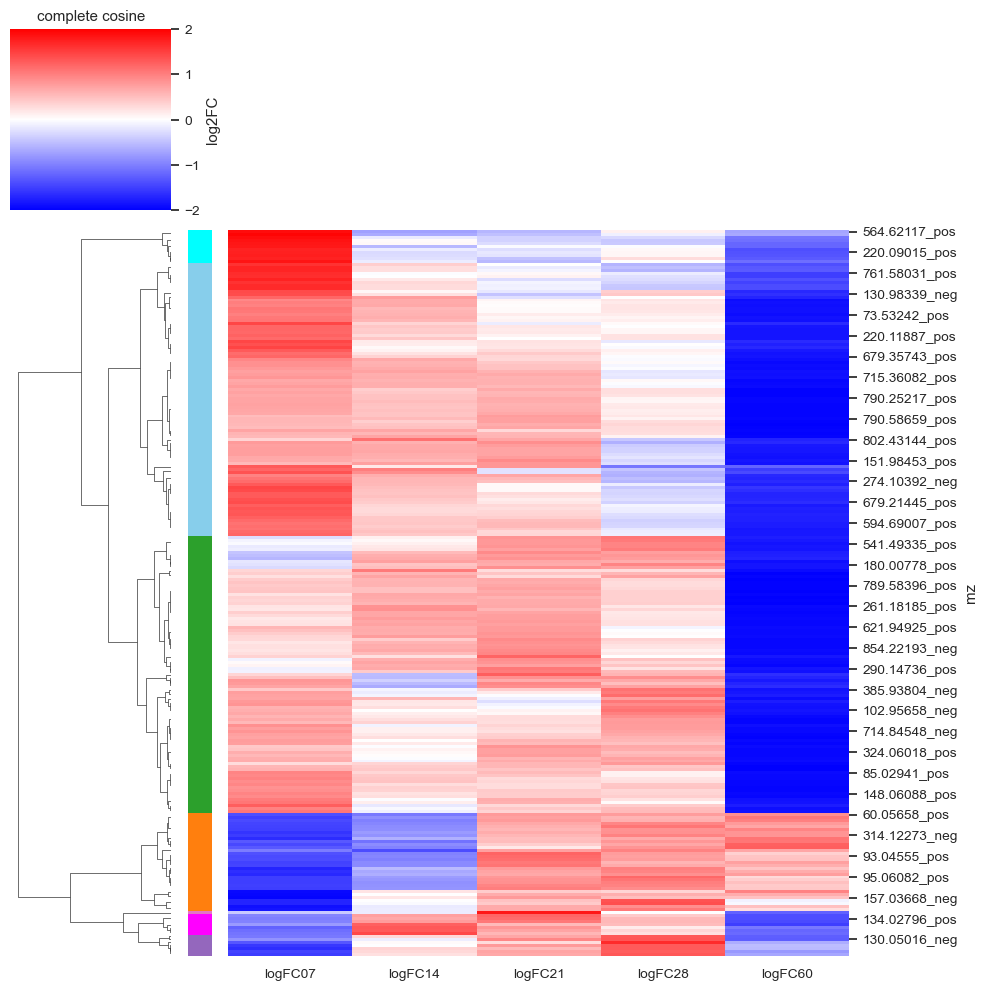

In [25]:
color_options = ['skyblue', 'tab:green', 'tab:orange', 'cyan', 'tab:purple', 'tab:pink', 'tab:green', 'magenta']
print(len(color_options))

k_colors = []
for i in range(len(zscore_profiles.index)):
  k_colors.append(color_options[groupings[i]])

# generate the figure with metabolite names
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.set(font_scale=0.9)
seaborn.clustermap(zscore_profiles, cmap='bwr', col_cluster=False, method=linkage_method, metric=distance_metric, cbar_kws={'label':'log2FC'}, row_colors=k_colors,vmin=-2, vmax=2)

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()

matplotlib.pyplot.show()
#matplotlib.pyplot.savefig('heatmap.svg')
#matplotlib.pyplot.clf()